In [2]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random

from joblib import dump
from optuna.samplers import TPESampler
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# CUDA
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE.type)

# Fix random seed
seed = 42
torch.manual_seed(seed)
if DEVICE.type == 'cuda':
	torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
sampler = TPESampler(seed=seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

optuna.logging.set_verbosity(optuna.logging.WARNING)

HYPERPARAMETERS_SEARCH = False

cuda


# Pre-processing input data

In [3]:
# train_df and test_df are created in eda notebook
if not os.path.exists('csv/train_df.csv') or not os.path.exists('csv/test_df.csv'):
	print('Please run the eda notebook first')
	exit()
train_df = pd.read_csv('csv/train_df.csv')
test_df = pd.read_csv('csv/test_df.csv')
target = 'total_time_target'
features = test_df.columns.copy().drop(target).drop(['benchmark','brand_raw', 'brand_raw_target','vendor_id_raw', 'arch'])

# Spearman U Kendall correlation feature selection > 0.4
# features = ["total_time","max_ram_usage","brk","munmap","rss","vms","shared","data"]
# mean error: 4.237189769744873 | std error: 10.339821815490723

# log for total_times
train_df[[target, 'total_time']] = np.log1p(train_df[[target, 'total_time']])
test_df[[target, 'total_time']] = np.log1p(test_df[[target, 'total_time']])

# Split data
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Normalize data
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

# Convert to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

if DEVICE.type == 'cuda':
	X_train = X_train.to(DEVICE)
	y_train = y_train.to(DEVICE)
	X_test = X_test.to(DEVICE)
	y_test = y_test.to(DEVICE)

In [4]:
if not os.path.exists('../models/x_scaler.joblib') or not os.path.exists('../models/y_scaler.joblib'):
	dump(x_scaler, '../models/x_scaler.joblib')
	dump(y_scaler, '../models/y_scaler.joblib')

# Model: Monte Carlo Dropout

In [6]:
class History:
	def __init__(self):
		self.loss = []
		self.val_loss = []
	
	def append(self, loss, val_loss):
		self.loss.append(loss)
		self.val_loss.append(val_loss)

def negative_log_likelihood(y, distribution):
    return -distribution.log_prob(y).mean()

def inv_scaling(y, y_scaler):
	if DEVICE.type == 'cuda':
		return y_scaler.inverse_transform(y.cpu().numpy().reshape(-1, 1))
	else:
		return y_scaler.inverse_transform(y.numpy().reshape(-1, 1))

In [7]:
class MCDropoutModel(nn.Module):
	def __init__(self, input_dim, n_hidden_layers, dropout=0.1):
		super(MCDropoutModel, self).__init__()
		if n_hidden_layers < 2:
			raise ValueError("n_hidden_layers must be greater than 1")
		# Input layer
		layers = [
			nn.Linear(input_dim, 200),
			nn.ReLU(),
			nn.Dropout(p=dropout),
		]
		# Hidden layers
		layers.extend([
			nn.Linear(200, 500),
			nn.ReLU(),
			nn.Dropout(p=dropout)
		])
		for _ in range(n_hidden_layers-2):
			layers.extend([
				nn.Linear(500, 500),
				nn.ReLU(),
				nn.Dropout(p=dropout)
			])
		layers.extend([
			nn.Linear(500, 200),
			nn.ReLU(),
			nn.Dropout(p=dropout)
		])
		# Output layer
		layers.append(nn.Linear(200, 2))
		self.model = nn.Sequential(*layers)
		
	def forward(self, x) -> torch.distributions.Normal:
		params = self.model(x)
		loc = params[:, 0:1]
		scale = 1e-6 + torch.nn.functional.softplus(0.33 * params[:, 1:2])
		return torch.distributions.Normal(loc, scale)
	
	def fit(self, X_train, y_train, X_test, y_test, epochs=1000, batch_size=32, learning_rate=0.0092, verbose=True, patience=50, num_runs=200):
		train_data = TensorDataset(X_train, y_train)
		test_data = TensorDataset(X_test, y_test)
		train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
		test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
		
		best_val_loss = np.inf
		epoch_no_improve = 0
		best_model_state = None
		optimizer = optim.Adam(self.parameters(), lr=learning_rate)
		history = History()

		for epoch in range(epochs):
			self.train()
			total_loss = 0
			for batch_X, batch_y in train_loader:
				optimizer.zero_grad()
				distribution = self(batch_X)
				loss = negative_log_likelihood(batch_y, distribution)
				loss.backward()
				optimizer.step()
				total_loss += loss.item()
			avg_loss = total_loss / len(train_loader)
			
			# validation loss
			self.eval()
			# Dropout layers should be in train mode for uncertainty estimation
			for m in self.model:
				if isinstance(m, nn.Dropout):
					m.train()
			total_val_loss = 0
			for batch_X, batch_y in test_loader:
				with torch.no_grad():
					distribution = self(batch_X)
				val_loss = negative_log_likelihood(batch_y, distribution)
				total_val_loss += val_loss.item()
			avg_val_loss = total_val_loss / len(test_loader)
			
			if verbose:
				print(f"Epoch: {epoch+1} - Loss: {avg_loss} - Val Loss: {avg_val_loss}")

			# Early stopping
			if avg_val_loss < best_val_loss:
				best_val_loss = avg_val_loss
				best_model_state = self.state_dict()
				epoch_no_improve = 0
			else:
				epoch_no_improve += 1
				if epoch_no_improve >= patience:
					print(f"Early stopping at epoch {epoch+1}")
					break
			history.append(avg_loss, avg_val_loss)
		
		if best_model_state is not None:
			self.load_state_dict(best_model_state)
			
		return history

	def predict(self, X, num_runs=250, full=False):
		self.eval()
		for m in self.model:
			if isinstance(m, nn.Dropout):
				m.train()
		with torch.no_grad():
			predictions = self(X).sample((num_runs,))
		if full:
			return predictions
		return torch.nn.functional.relu(predictions.mean(axis=0))

# Hyperparameters Optimization

In [39]:
def objective(trial: optuna.Trial, X_train, y_train, X_test, y_test, input_dim):
	dropout = trial.suggest_float('dropout', 0.1, 0.5)
	n_hidden_layers = trial.suggest_int('n_hidden_layers', 2, 10)
	learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
	num_epochs = trial.suggest_int('num_epochs', 100, 1000)

	# Model initialization 
	model = MCDropoutModel(input_dim, n_hidden_layers, dropout)
	if DEVICE.type == 'cuda':
		model = model.to(DEVICE)
	# Fit model
	history = model.fit(X_train, y_train, X_test, y_test, epochs=num_epochs, learning_rate=learning_rate)
	loss = history.loss[-1]
	val_loss = history.val_loss[-1]
	print(f"Trial: {trial.number} - NLL Loss: {loss} - NLL Val Loss: {val_loss} - epochs: {len(history.loss)}")
	return val_loss.item()

n_trials = 250
study = None

In [40]:
if HYPERPARAMETERS_SEARCH:
	study = optuna.create_study(direction='minimize', sampler=sampler)
	study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, len(features)), n_trials=n_trials)

In [41]:
if study is not None:
	print(f'Number of trials: {len(study.trials)}')
	trial = study.best_trial
	print(f'Best trial: {trial.number}')
	print(f'Best params: {trial.params}')
	print(f'Best validation loss: {np.reshape(trial.value, (-1,1)).item()}')

# Training

In [42]:
# Hyperparameters
if study is not None:
	dropout = study.best_trial.params['dropout']
	n_hidden_layers = study.best_trial.params['n_hidden_layers']
	lr = study.best_trial.params['learning_rate']
	num_epochs = study.best_trial.params['num_epochs']
else:
	dropout = 0.1
	n_hidden_layers = 3
	lr = 0.0002
	num_epochs = 100

In [43]:
# Model initialization 
model = MCDropoutModel(len(features), n_hidden_layers, dropout)
if DEVICE.type == 'cuda':
	model = model.to(DEVICE)
# Fit model
history = model.fit(X_train, y_train, X_test, y_test, epochs=num_epochs, learning_rate=lr, patience=25)
loss = history.loss[-1]
val_loss = history.val_loss[-1]

Epoch: 1 - Loss: -1.4480821958437295 - Val Loss: -1.8346695069110754
Epoch: 2 - Loss: -2.000135411985376 - Val Loss: -2.0551083493026305
Epoch: 3 - Loss: -2.1669547775747198 - Val Loss: -2.160557486858719
Epoch: 4 - Loss: -2.275641395054101 - Val Loss: -2.24831566524196
Epoch: 5 - Loss: -2.351159436435813 - Val Loss: -2.3953413354369983
Epoch: 6 - Loss: -2.4265450344916095 - Val Loss: -2.262795519003104
Epoch: 7 - Loss: -2.470879515678319 - Val Loss: -2.457502229582696
Epoch: 8 - Loss: -2.5144326634636567 - Val Loss: -2.2632245875540233
Epoch: 9 - Loss: -2.5484358189620475 - Val Loss: -2.4237082480610193
Epoch: 10 - Loss: -2.5716545067973366 - Val Loss: -2.510124090236503
Epoch: 11 - Loss: -2.6137225711713166 - Val Loss: -2.2683945488813637
Epoch: 12 - Loss: -2.6372607572456515 - Val Loss: -2.45439113102434
Epoch: 13 - Loss: -2.6586391250142025 - Val Loss: -2.5867099694875413
Epoch: 14 - Loss: -2.6707635734324975 - Val Loss: -2.555584209563928
Epoch: 15 - Loss: -2.6909042759931947 - Va

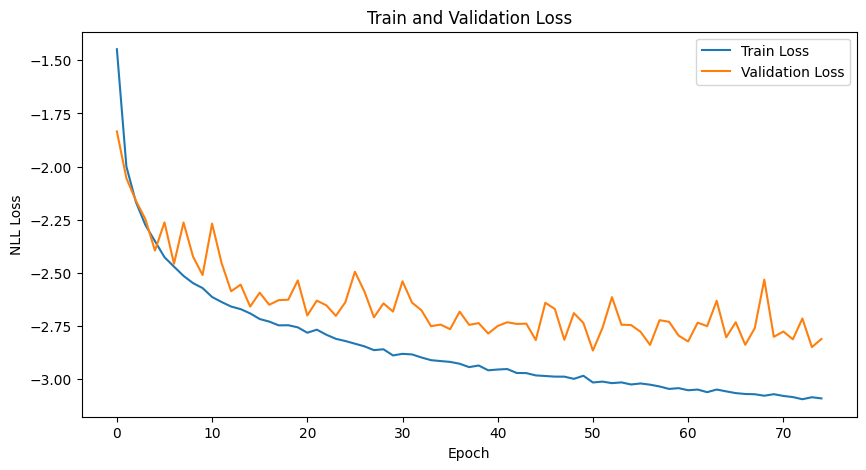

In [44]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.loss, label='Train Loss')
plt.plot(history.val_loss, label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('NLL Loss')
plt.legend()
plt.show()

In [45]:
# Save model
torch.save(model, '../models/mc_dropout_model.pt')

# Describe Validation

In [8]:
if DEVICE.type == 'cuda':
	model = torch.load('../models/mc_dropout_model.pt').to(DEVICE)
else:
	model = torch.load('../models/mc_dropout_model.pt', map_location=torch.device('cpu'))

In [9]:
def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}
	predictions = model.predict(X)
	predictions = np.expm1(inv_scaling(predictions, y_scaler))
	y_scaled = np.expm1(inv_scaling(y, y_scaler))
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [10]:
test_df_og = pd.read_csv('csv/test_df.csv')

In [28]:
_, _, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = np.expm1(inv_scaling(y_test, y_scaler))
df = pd.DataFrame(predictions, columns=['predictions'])
df['actual'] = y_scaled
df.to_csv('csv/predictions_mcdropout.csv', index=False)

In [11]:
print("Validation set single thread model")
min_instance, max_instance, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled_full = np.expm1(inv_scaling(y_test, y_scaler))
errors = np.abs(predictions - y_scaled_full)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled_full)} | Std actual: {np.std(y_scaled_full)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 24.95842933654785 | Std actual: 48.91020965576172
Mean actual: 23.631031036376953 | Std actual: 41.60096740722656
Mean Error: 4.292510509490967 | Std Error: 14.878805160522461
Min instance
total_time                                                             0.15
total_cpu_usage                                                        0.98
max_ram_usage                                                     13.203125
brand_raw                         Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    24
l2_cache_size                                                           6.0
l3_cache_size                                                          30.0
l2_cache_line_size                                                      256

# Analysis of Results

In [12]:
sorted_index = test_df_og.sort_values(by='total_time_target').index

In [13]:
runs = 1000
predictions = np.zeros((runs, y_scaled_full.shape[0], 1))
for i in range(runs):
	predictions[i] = np.expm1(inv_scaling(model.predict(X_test), y_scaler))

In [14]:
# sort test_df values and order predictions by the same order
predictions = predictions[:, sorted_index, :]
y_scaled_full = y_scaled_full[sorted_index]

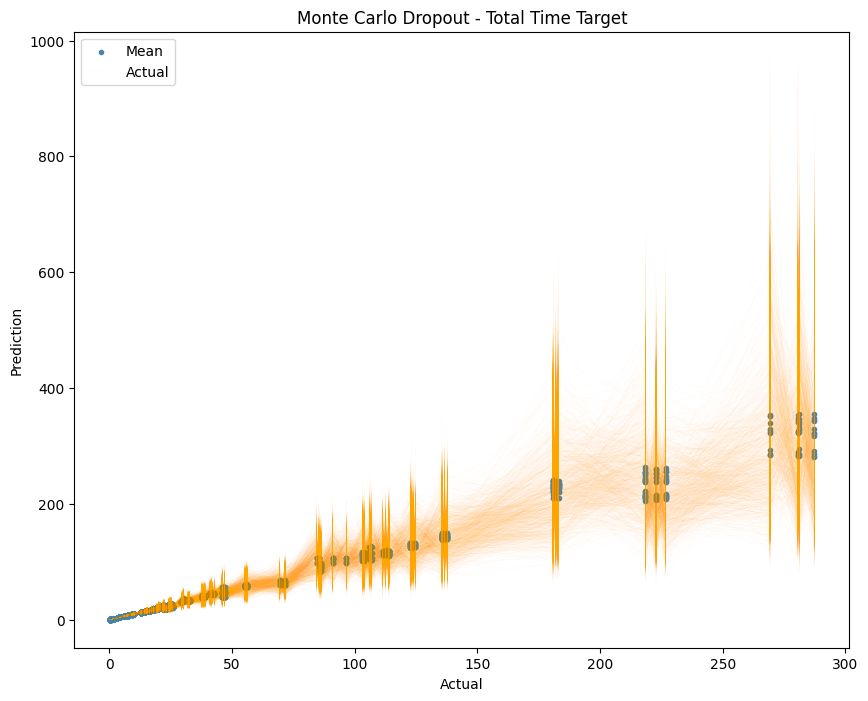

In [34]:
plt.figure(figsize=(10, 8))
plt.scatter(y_scaled_full, predictions.mean(axis=0), color="steelblue", alpha=1, marker=".")
for i in range(runs):
	plt.plot(test_df_og['total_time_target'].iloc[sorted_index], predictions[i], color="orange", linewidth=0.1, alpha=0.1)
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Monte Carlo Dropout - Total Time Target")
plt.legend(["Mean", "Actual"])
plt.show()

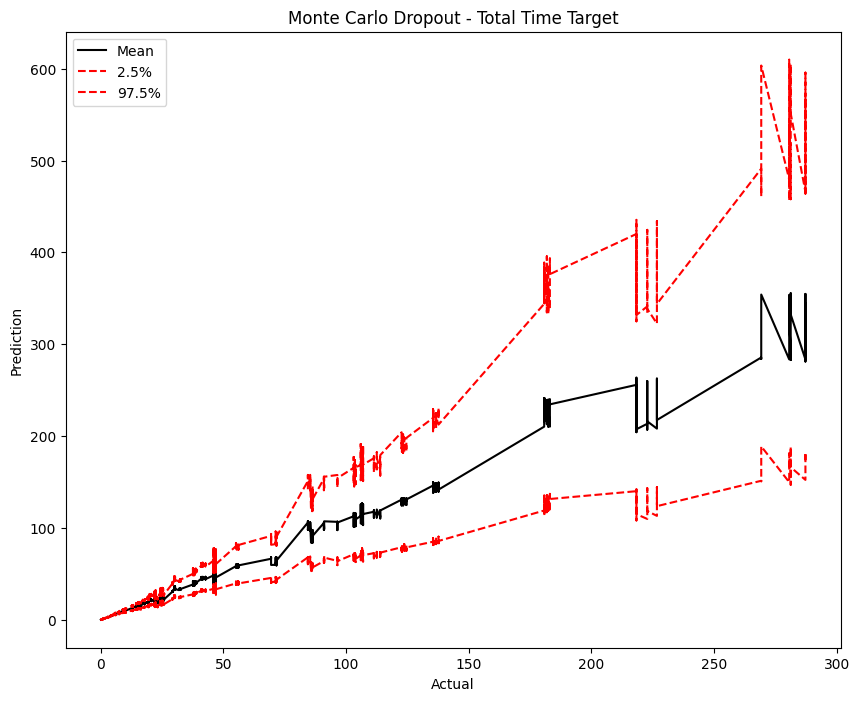

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(test_df_og['total_time_target'].iloc[sorted_index], np.mean(predictions, axis=0), color="black", linewidth=1.5)
plt.plot(test_df_og['total_time_target'].iloc[sorted_index], np.quantile(predictions, 0.025, axis=0), color="red", linewidth=1.5, linestyle="--")
plt.plot(test_df_og['total_time_target'].iloc[sorted_index], np.quantile(predictions, 0.975, axis=0), color="red", linewidth=1.5, linestyle="--")
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Monte Carlo Dropout - Total Time Target")
plt.legend(["Mean", "2.5%", "97.5%"])
plt.show()

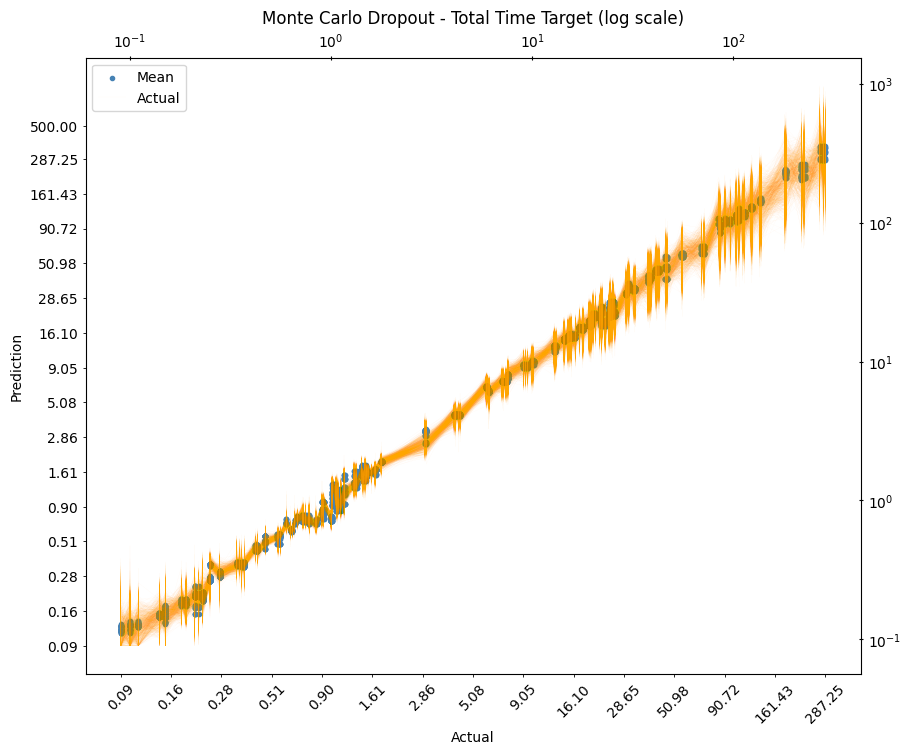

In [33]:
plt.figure(figsize=(10, 8))
plt.scatter(y_scaled_full, predictions.mean(axis=0), color="steelblue", alpha=1, marker=".")
for i in range(runs):
	plt.plot(y_scaled_full, predictions[i], color="orange", linewidth=0.1, alpha=0.1)
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Monte Carlo Dropout - Total Time Target (log scale)")
plt.yscale('log')  
plt.xscale('log')  
bins = np.logspace(np.log10(test_df_og["total_time_target"].min()), np.log10(test_df_og["total_time_target"].max()), 15)
plt.gca().set_xticks(bins, minor=True)
plt.gca().set_xticklabels([f"{x:.2f}" for x in bins], minor=True, ha='center')
plt.gca().tick_params(axis='x', which='minor', bottom=True, top=False, labelbottom=True, labeltop=False, rotation=45)
plt.gca().tick_params(axis='x', which='major', top=True, bottom=False, labelbottom=False, labeltop=True, direction='inout')
plt.gca().set_yticks([*bins,500], minor=True)
plt.gca().set_yticklabels([f"{y:.2f}" for y in [*bins,500]], minor=True, ha='right')
plt.gca().tick_params(axis='y', which='minor', left=True, right=False, labelleft=True, labelright=False)
plt.gca().tick_params(axis='y', which='major', right=True, left=False, labelleft=False, labelright=True, direction='inout')
plt.legend(["Mean", "Actual"])
plt.show()

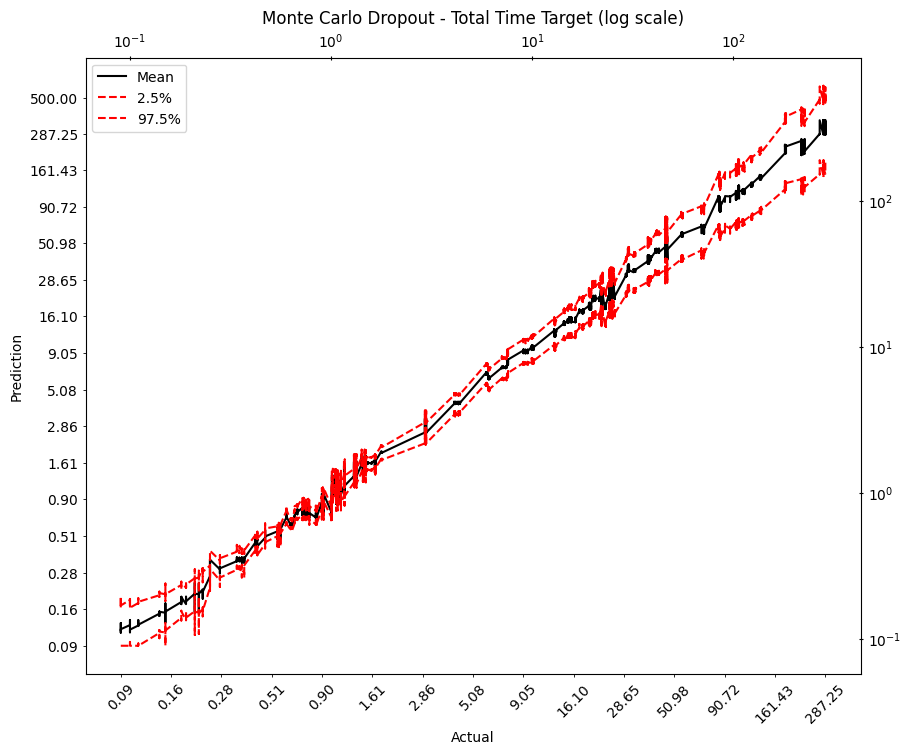

In [32]:
plt.figure(figsize=(10, 8))
plt.plot(y_scaled_full, np.mean(predictions, axis=0), color="black", linewidth=1.5)
plt.plot(y_scaled_full, np.quantile(predictions, 0.025, axis=0), color="red", linewidth=1.5, linestyle="--")
plt.plot(y_scaled_full, np.quantile(predictions, 0.975, axis=0), color="red", linewidth=1.5, linestyle="--")
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Monte Carlo Dropout - Total Time Target (log scale)")
plt.yscale('log')  
plt.xscale('log')  
bins = np.logspace(np.log10(test_df_og["total_time_target"].min()), np.log10(test_df_og["total_time_target"].max()), 15)
plt.gca().set_xticks(bins, minor=True)
plt.gca().set_xticklabels([f"{x:.2f}" for x in bins], minor=True, ha='center')
plt.gca().tick_params(axis='x', which='minor', bottom=True, top=False, labelbottom=True, labeltop=False, rotation=45)
plt.gca().tick_params(axis='x', which='major', top=True, bottom=False, labelbottom=False, labeltop=True, direction='inout')
plt.gca().set_yticks([*bins,500], minor=True)
plt.gca().set_yticklabels([f"{y:.2f}" for y in [*bins,500]], minor=True, ha='right')
plt.gca().tick_params(axis='y', which='minor', left=True, right=False, labelleft=True, labelright=False)
plt.gca().tick_params(axis='y', which='major', right=True, left=False, labelleft=False, labelright=True, direction='inout')
plt.legend(["Mean", "2.5%", "97.5%"])
plt.show()